# Face Recognition using FaceNet

In this notebook, we will build a face recognition system. Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) and [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf). 

Face recognition problems commonly fall into two categories: 

- **Face Verification** - "is this the claimed person?". For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem. 
- **Face Recognition** - "who is this person?". For example, [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem. 

***FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.***

<img src="images/distance_kiank.png" style="width:680px;height:250px;">
<br>
<caption><center> <u> <font color='purple'> **Figure 1**: </u> </caption>
    
### In this notebook:
- Use a pretrained model to map face images into 128-dimensional encodings
- Use **Inception** for encoding
- Use these encodings to perform face verification and face recognition

## Load packages
Let's load the required packages. 

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

from IPython.display import Image, display

%matplotlib inline
%reload_ext autoreload
%autoreload 2

#np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


## 0 - Naive Face Verification

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to **compare the two images pixel-by-pixel**. If the distance between the raw images are less than a chosen threshold, it may be the same person! 

* Of course, this algorithm performs really poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, even minor changes in head position, and so on. 
* You'll see that rather than using the raw image, you can learn an encoding.  
* By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

## 1 - Encoding face images into a 128-dimensional vector 

### 1.1 - Using a ConvNet  to compute encodings

The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning, let's  load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al.*](https://arxiv.org/abs/1409.4842). We have provided an inception network implementation. You can look in the file `inception_blocks_v2.py` to see how it is implemented. 

The key things you need to know are:

- This network uses 96x96 dimensional RGB images as its input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$ 
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

The cell below is to create the model for face images.

In [3]:
# Function_body : inception_blocks_v2.py
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [4]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings to compare two face images as follows:

<img src="images/distance_kiank.png" style="width:680px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 2**: <br> </u> <font color='purple'> By computing the distance between two encodings and thresholding, you can determine if the two pictures represent the same person</center></caption>

So, an encoding is a good one if: 
- The encodings of two images of the same person are quite similar to each other. 
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart. 

<img src="images/triplet_comparison.jpg" style="width:480px;height:350px;">
<br>
<caption><center> <u> <font color='purple'> **Figure 3**: </u> </caption>

## 2 - Loading the pre-trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. Load a model using the following cell; this might take a couple of minutes to run. 

In [5]:
print("Start model loading...")
# Function triplet_loss body : fr_utils.py
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
# Function load_weights_from_FaceNet body : fr_utils.py
load_weights_from_FaceNet(FRmodel)
print("Model loaded")

Start model loading...
Model loaded


Let's now use this model to perform face verification and face recognition! 

## 3 - Applying the model

Let's build a database containing one encoding vector for each person whom we want recognize. To generate the encoding we use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image. 

In [7]:
database = {}
database["Bill_gates"] = img_to_encoding("images/Bill_gates.jpg", FRmodel)
database["Donald_trump"] = img_to_encoding("images/Donald_trump.jpg", FRmodel)
database["Drioueche_mohammed"] = img_to_encoding("images/Drioueche_mohammed.jpg", FRmodel)
database["J_K_Rowling"] = img_to_encoding("images/J_K_Rowling.jpg", FRmodel)
database["Kendall_jenner"] = img_to_encoding("images/Kendall_jenner.jpg", FRmodel)

### 3.1 - Face Verification

Now we'll implement a face verification system that takes as input an image, and ID (name) and figures out if it is one of the persons saved in the database.

You are going to find the **verify function** body in fr_utils.py.

**protype:** `verify(image_path, identity, database, model)`

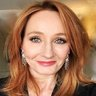

It's J_K_Rowling, welcome in!


(0.6896378397941589, True)

In [8]:
display(Image(filename="images/test_2.jpg"))
verify("images/test_2.jpg", "J_K_Rowling", database, FRmodel)

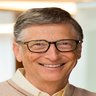

It's not Donald_trump, please go away


(0.8789433240890503, False)

In [9]:
display(Image(filename="images/test_3.jpg"))
verify("images/test_3.jpg", "Donald_trump", database, FRmodel)

### 3.2 - Face Recognition

Now we'll implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). 

Unlike the previous face verification system, we will no longer get a person's name as one of the inputs. 

You are going to find the **who_is_it function** body in fr_utils.py.

**protype:** `who_is_it(image_path, database, model)`

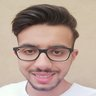

it's Drioueche_mohammed, the distance is 0.61233467


(0.61233467, 'Drioueche_mohammed')

In [10]:
display(Image(filename="images/test_0.jpg"))
who_is_it("images/test_0.jpg", database, FRmodel)

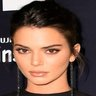

it's Kendall_jenner, the distance is 0.6609955


(0.6609955, 'Kendall_jenner')

In [11]:
display(Image(filename="images/test_1.jpg"))
who_is_it("images/test_1.jpg", database, FRmodel)

## 4 - Ways to improve the facial recognition model
Here are some ways to further improve the algorithm:
- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.
- Crop the images to just contain the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.


## 5- Conclusion
- Face verification solves an easier 1:1 matching problem.
- Face recognition addresses a harder 1:K matching problem. 
- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person. 

### References:

- Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) 
- The pretrained model we use is inspired by Victor Sy Wang's implementation and was loaded using his code: https://github.com/iwantooxxoox/Keras-OpenFace.
- Our implementation also took a lot of inspiration from the official FaceNet github repository: https://github.com/davidsandberg/facenet 
- This notebook is based on [Convolutional Neural Networks Course](https://www.coursera.org/learn/convolutional-neural-networks?specialization=deep-learning) offered by deeplearning.ai on coursera.